In [1]:
%cd ../..

/gpfs/home/vhl2022/projects/rcpp


In [40]:
def largest_minute_percent_move(df_filtered: pd.DataFrame) -> pd.Series:
    # Ensure data is sorted by time
    df_sorted = df_filtered.sort_index()
    
    # Compute percent change in "Close" column
    pct_change = df_sorted["Close"].pct_change()
    
    # Get the row with the largest absolute percent change
    max_change_idx = pct_change.abs().idxmax()
    
    # Return the relevant row and percentage change
    return pd.Series({
        "timestamp": max_change_idx,
        "percent_change": pct_change.loc[max_change_idx],
        "previous_close": df_sorted["Close"].shift(1).loc[max_change_idx],
        "current_close": df_sorted["Close"].loc[max_change_idx],
    })

largest_move = largest_minute_percent_move(df_filtered)
largest_move

timestamp         6.800427e+06
percent_change   -3.547564e-02
previous_close    9.637600e+04
current_close     9.295700e+04
dtype: float64

# Filtered Data

In [ ]:
# df_filtered.to_csv("btcusd_1-min_data_filtered.csv", index=False)

In [6]:
import pandas as pd
df = pd.read_csv("./applications/market_making/data/btcusd_1-min_data_filtered.csv")
df.head()

,Timestamp,Close
0,1.672531e+09,16568.0
1,1.672531e+09,16569.0
2,1.672531e+09,16569.0
3,1.672531e+09,16568.0
4,1.672531e+09,16565.0


In [7]:
target = (df["Close"].shift(-1) / df["Close"]) * 100000

In [9]:
import numpy as np
np.var(target - 100000, ddof=1)

np.float64(4520.779777520369)

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np


def compute_loss(df_filtered: pd.DataFrame, lambda_: float, RHO: float, SIGMA: float, filter_nans: bool = True) -> np.ndarray:
    """Given a DataFrame with 'Close' prices, compute the profit."""
    df = df_filtered.copy()

    # Compute target: normalize current price to 100k, then scale next_close accordingly
    target = (df["Close"].shift(-1) / df["Close"]) * 100000

    # Compute prediction: average of current and previous 4 closes. Assume simple mean model.
    pred = df["Close"].rolling(window=5).mean() / df["Close"] * 100000

    bid = pred - RHO * lambda_ / 2
    ask = pred + RHO * lambda_ / 2

    # Assume investor belief is a normal distribution with mean df['target'] and std SIGMA
    volume_on_bid = norm.cdf(bid, loc=target, scale=SIGMA)
    volume_on_ask = 1 - norm.cdf(ask, loc=target, scale=SIGMA)

    profit = volume_on_bid * (target - bid) + volume_on_ask * (ask - target)
    loss = - profit

    if filter_nans:
        loss = loss[~np.isnan(loss)]

    return np.array(loss)


In [102]:
# Spread, assuming bitcoin is normalized to 100k
# Std of price beliefs, assuming bitcoin is normalized
        
rho, sigma = 100, 200
delta_prime = 0.5

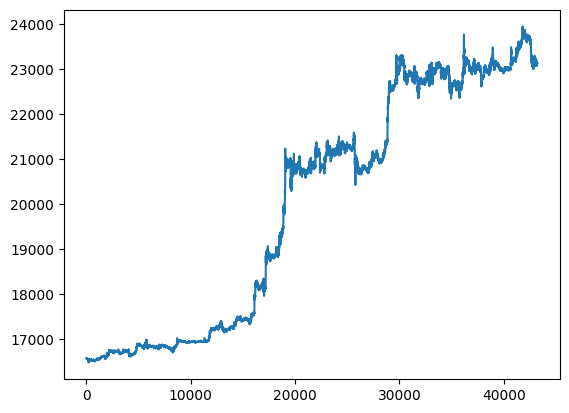

In [103]:
plt.plot(df_filtered[mask]['Close'])

In [108]:
print(np.mean(compute_loss(df_filtered[mask], 0.0, rho, sigma)))
print(np.mean(compute_loss(df_filtered[mask], 1.0, rho, sigma)))

20.771946373157096
-20.28840974985965


In [109]:
# On the first month in 2023, compute the variance
index = pd.to_datetime(df_filtered['Timestamp'], unit='s')
start_date = pd.Timestamp('2023-01-01')
end_date = pd.Timestamp('2023-01-31')
mask = (index >= start_date) & (index <= end_date)

lambdas = np.linspace(0.0, 1.0, 101)

clt_bounds = []
for lambda_ in lambdas:
    tp_jan = compute_loss(df_filtered[mask], lambda_, rho, sigma)
    clt_var = np.var(tp_jan, ddof=1)
    clt_bound = norm.ppf(1 - delta_prime / 2) * np.sqrt(clt_var) / np.sqrt(len(tp_jan))
    clt_bounds.append(clt_bound)

print(f"Variance of profit in January 2023: {clt_bounds}")

Variance of profit in January 2023: [np.float64(0.2268354353113778), np.float64(0.2268349463797402), np.float64(0.22683347959716177), np.float64(0.2268310350006459), np.float64(0.22682761265186305), np.float64(0.22682321263714877), np.float64(0.22681783506749986), np.float64(0.22681148007857058), np.float64(0.22680414783066688), np.float64(0.2267958385087407), np.float64(0.22678655232238232), np.float64(0.22677628950581272), np.float64(0.22676505031787392), np.float64(0.22675283504201937), np.float64(0.2267396439863029), np.float64(0.2267254774833667), np.float64(0.22671033589042813), np.float64(0.22669421958926655), np.float64(0.2266771289862078), np.float64(0.22665906451210893), np.float64(0.22664002662234117), np.float64(0.22662001579677252), np.float64(0.22659903253974895), np.float64(0.2265770773800748), np.float64(0.22655415087099257), np.float64(0.22653025359016107), np.float64(0.2265053861396333), np.float64(0.226479549145833), np.float64(0.22645274325953021), np.float64(0.2264

In [112]:
tp_jan

array([-39.06029378, -39.46910151, -39.86187942, ..., -38.64955673,
       -38.09248044, -40.08458233], shape=(43196,))

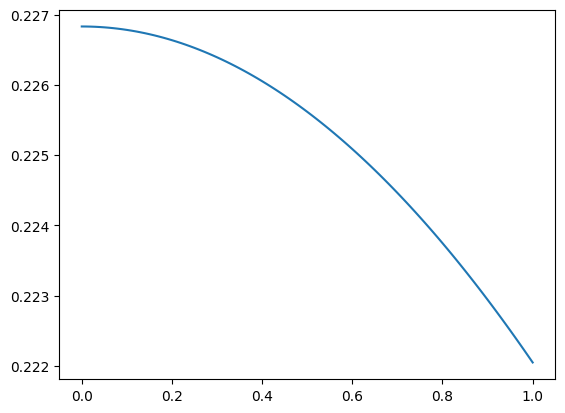

In [111]:
plt.plot(lambdas, clt_bounds)

In [79]:
print(np.nanmean(compute_loss(df_filtered, 0.0)))
print(np.nanmean(compute_loss(df_filtered, 0.2)))
print(np.nanmean(compute_loss(df_filtered, 0.5)))
print(np.nanmean(compute_loss(df_filtered, 0.8)))
print(np.nanmean(compute_loss(df_filtered, 1.0)))

27.74274898045471
18.089029492844087
4.902926570654566
-6.746475474876325
-13.674295895835748
